Imports and Useful Functions

In [9]:
from tools import show_df, edit_year_format

from nba_api.stats.endpoints import teamyearbyyearstats
from nba_api.stats.static import teams

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

import time

Get Team IDs

In [ ]:
all_teams = teams.get_teams()
teams_df = pd.DataFrame(all_teams)

teams_df = teams_df.rename(columns={
    'id': 'ID',
    'abbreviation': 'ABBR',
    'nickname': 'NICKNAME',
    'city': 'CITY'
})

teams_df = teams_df[['ID', 'CITY', 'NICKNAME', 'ABBR']]

show_df(teams_df)

Team Totals, by Season

In [3]:
cols = ['YEAR', 'TEAM_ID', 'GP', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']

year_data = []

for i, row in teams_df.iterrows():
    team = teamyearbyyearstats.TeamYearByYearStats(team_id=row['ID'])
    team_stats = team.get_data_frames()[0]
    
    year_start = team_stats['YEAR'].str[:4].astype(int)
    team_stats = team_stats[year_start >= 1976]

    time.sleep(0.5)
    
    for j, year in team_stats.iterrows():
        row_data = [
            edit_year_format(year['YEAR']),
            year['TEAM_ID'],
            year['GP'],
            year['FGM'],
            year['FGA'],
            year['FG3M'],
            year['FG3A'],
            year['FTM'],
            year['FTA'],
            year['REB'],
            year['AST'],
            year['STL'],
            year['BLK'],
            year['TOV'],
            year['PTS']
        ]
        year_data.append(row_data)


team_season_totals = pd.DataFrame(year_data, columns=cols)

# show_df(team_season_totals.sort_values(by='YEAR', ascending=True))

Team Averages Per Game, by Season

In [ ]:
cols = ['YEAR', 'TEAM_ID', 'GP', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']

year_data = []

for i, row in teams_df.iterrows():
    team = teamyearbyyearstats.TeamYearByYearStats(team_id=row['ID'])
    team_stats = team.get_data_frames()[0]
    
    year_start = team_stats['YEAR'].str[:4].astype(int)
    team_stats = team_stats[year_start >= 1976]

    time.sleep(0.5)
    
    for j, year in team_stats.iterrows():
        row_data = [
            edit_year_format(year['YEAR']),
            year['TEAM_ID'],
            year['GP'],
            round(year['FGM'] / year['GP'], 2),
            round(year['FGA'] / year['GP'], 2),
            round(year['FG3M'] / year['GP'], 2),
            round(year['FG3A'] / year['GP'], 2),
            round(year['FTM'] / year['GP'], 2),
            round(year['FTA'] / year['GP'], 2),
            round(year['REB'] / year['GP'], 2),
            round(year['AST'] / year['GP'], 2),
            round(year['STL'] / year['GP'], 2),
            round(year['BLK'] / year['GP'], 2),
            round(year['TOV'] / year['GP'], 2),
            round(year['PTS'] / year['GP'], 2)
        ]
        year_data.append(row_data)


team_season_per_game_stats = pd.DataFrame(year_data, columns=cols)

show_df(team_season_per_game_stats.sort_values(by='YEAR', ascending=True))

League Average Team Stats Per Game, Per Season

In [ ]:
per_season_cols = ['YEAR', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']

season_stats = {}

for i, row in team_season_totals.iterrows():
    year = row['YEAR']
    if year not in season_stats:
        season_stats[year] = []
    season_stats[year].append([
        row['GP'],
        row['FGM'],
        row['FGA'],
        row['FG3M'],
        row['FG3A'],
        row['FTM'],
        row['FTA'],
        row['REB'],
        row['AST'],
        row['STL'],
        row['BLK'],
        row['TOV'],
        row['PTS']
    ])

season_avgs = []

for year, team_stats_list in sorted(season_stats.items()):
    season = np.array([0] * 12)
    total_games_played = 0
    for team_stats in team_stats_list:
        team_stats_np = np.array(team_stats[1:])
        season = season + team_stats_np
        total_games_played += team_stats[0]
    season = season / total_games_played
    season_avgs.append([year] + season.tolist())

league_avg_stats = pd.DataFrame(season_avgs, columns=per_season_cols)

show_df(league_avg_stats)

In [ ]:
# convert the season to a number, for regression
years = league_avg_stats['YEAR'].str[:4].astype(int).to_frame()

last_year = years['YEAR'].max()
future_years = pd.DataFrame(np.arange(last_year + 1, last_year + 5), columns=years.columns)

projections = {}

# exponential smoothing span
future_years_count = len(future_years)
span = 5
trend_n = 3

for col in ['FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']:
    y = league_avg_stats[col]

    # compute exponentially weighted moving average
    smoothed = y.ewm(span=span, adjust=False).mean()
    
    # use last smoothed value for future projections
    slope = (smoothed.iloc[-1] - smoothed.iloc[-trend_n]) / trend_n
    
    # project forward along slope
    proj = smoothed.iloc[-1] + slope * np.arange(1, future_years_count+1)
    
    projections[col] = proj

# re-format the future years to match avg_stats df, and merge into one df
future_years_formatted = future_years['YEAR'].astype(str) + '-' + (future_years['YEAR'] + 1).astype(str)

future_df = pd.DataFrame(future_years_formatted, columns=['YEAR'])
for col in projections:
    future_df[col] = projections[col]

league_avg_w_proj = pd.concat([league_avg_stats, future_df])

# add integer year
league_avg_w_proj['YEAR_INT'] = pd.concat([years, future_years])
league_avg_w_proj = league_avg_w_proj[['YEAR'] + ['YEAR_INT']
                        + [c for c in league_avg_w_proj.columns if c != 'YEAR_INT' and c != 'YEAR']]

show_df(league_avg_w_proj)

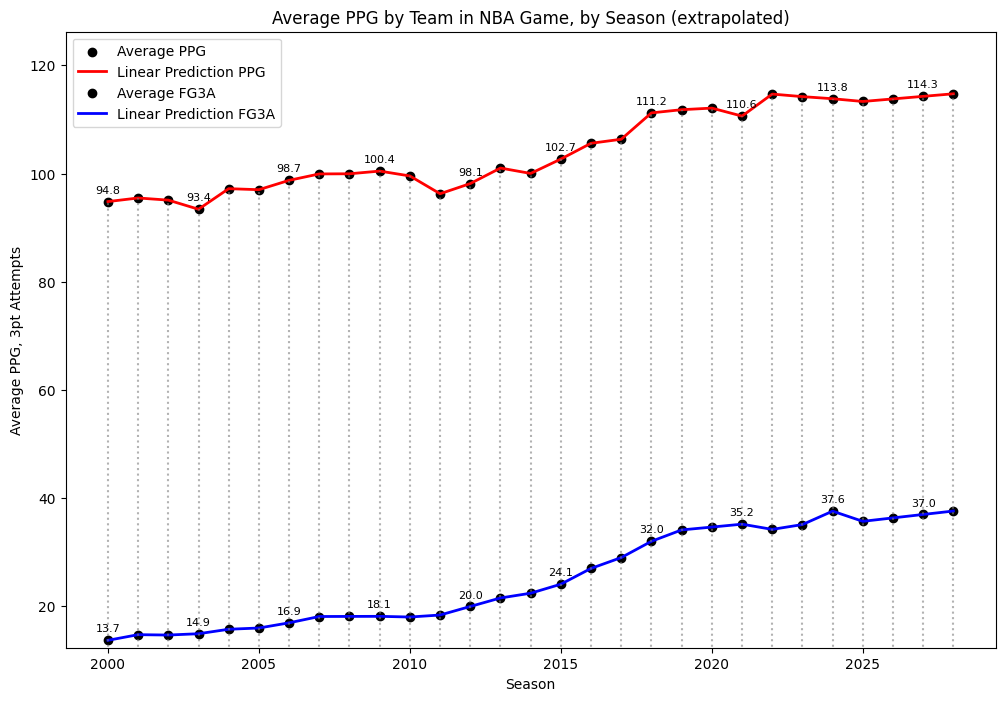

In [7]:
# now I want to see the predictions graphed out, since these don't make a ton of sense

plot_df = league_avg_w_proj[league_avg_w_proj['YEAR_INT'] >= 2000]
X = plot_df[['YEAR_INT']]
y1 = plot_df['PTS']
y2 = plot_df['FG3A']

plt.figure(figsize=(12,8))
plt.scatter(X, y1, color='black', label='Average PPG')
plt.plot(X, y1, color='red', linewidth=2, label='Linear Prediction PPG')

plt.scatter(X, y2, color='black', label='Average FG3A')
plt.plot(X, y2, color='blue', linewidth=2, label='Linear Prediction FG3A')

count = 0
for year, pts in zip(plot_df['YEAR_INT'], y1):
    plt.vlines(x=year, ymin=0, ymax=pts, linestyles='dotted', color='gray', alpha=0.6)
    if count % 3 == 0:
        plt.text(year, pts + 1.2, f'{pts:.1f}', ha='center', va='bottom', fontsize=8)
    count += 1

count = 0
for year, fg3a in zip(plot_df['YEAR_INT'], y2):
    if count % 3 == 0:
        plt.text(year, fg3a + 1.2, f'{fg3a:.1f}', ha='center', va='bottom', fontsize=8)
    count += 1

plt.ylim(plot_df['FG3A'].min() * 0.9, plot_df['PTS'].max() * 1.1)
plt.xlabel('Season')
plt.ylabel('Average PPG, 3pt Attempts')
plt.title('Average PPG by Team in NBA Game, by Season (extrapolated)')
plt.legend()
plt.margins(y=0)
plt.show()